<a href="https://colab.research.google.com/github/hanumantjain/PyTorch/blob/main/TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install opendatasets --quiet
!pip install transformers --quiet

# Import opendatasets for downloading datasets
import opendatasets as od

# Download the dataset from Kaggle
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hanumantjain
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 774MB/s]

In [2]:
# Import necessary PyTorch and other libraries
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Determine the device to use (GPU if available, otherwise CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# Load the dataset from the downloaded JSON file
data_df = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)

# Drop rows with missing values
data_df.dropna(inplace =True)

# Drop duplicate rows
data_df.drop_duplicates(inplace =True)

# Print the shape of the dataframe (number of rows and columns)
print(data_df.shape)

# Display the first 5 rows of the dataframe
data_df.head()

(26708, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
# Drop the 'article_link' column as it is not needed for the model
data_df.drop(("article_link"), inplace=True, axis=1)

# Display the first 5 rows of the modified dataframe
data_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
# Split the data into training, testing, and validation sets
# First, split into training (70%) and a combined test/validation set (30%)
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size=0.3)

# Then, split the combined test/validation set into validation (50% of the 30%, so 15% of total) and test (50% of the 30%, so 15% of total)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

# Print the sizes of the training, testing, and validation sets
print("Training Size: ", X_train.shape[0], "Which is ", round(X_train.shape[0]/data_df.shape[0]* 100, 4),'%')
print("Testing Size: ", X_test.shape[0], "Which is ", round(X_test.shape[0]/data_df.shape[0]* 100, 4),'%')
print("Validation Size: ", X_val.shape[0], "Which is ", round(X_val.shape[0]/data_df.shape[0]* 100, 4),'%')

Training Size:  18695 Which is  69.9978 %
Testing Size:  4007 Which is  15.003 %
Validation Size:  4006 Which is  14.9993 %


In [6]:
# Load the BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Orginial - ['Hello how are you?']
Tokens -> [123,45,645,64,0,0,0,......0]

In [7]:
# Define a custom dataset class for handling the data
class dataset(Dataset):
  def __init__(self, X, Y):
    # Tokenize the input headlines and convert them to PyTorch tensors
    self.X = [tokenizer(x,
                        max_length = 100,        # Maximum length of the tokenized sequence
                        truncation = True,       # Truncate sequences longer than max_length
                        padding='max_length',    # Pad sequences shorter than max_length
                        return_tensors = 'pt').to(device) # Return PyTorch tensors and move to device
                        for x in X]
    # Convert the labels to PyTorch tensors and move to device
    self.Y = torch.Tensor(Y).to(device).type(torch.float32)

  # Return the number of samples in the dataset
  def __len__(self):
    return len(self.X)

  # Return a sample (input and label) at a given index
  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

# Create instances of the custom dataset for training, validation, and testing
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
test_data = dataset(X_test, y_test)

In [8]:
# Define hyperparameters
BATCH_SIZE = 32  # Batch size for training
EPOCHS = 10      # Number of training epochs
LR = 1e-4        # Learning rate for the optimizer

In [9]:
# Create DataLoaders for iterating over the datasets in batches
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# Define the neural network model
class MyModel(nn.Module):
  def __init__(self, bert):
    super(MyModel, self).__init__()

    # Use the pre-trained BERT model
    self.bert = bert
    # Dropout layer for regularization
    self.dropout = nn.Dropout(0.25)
    # Linear layers for classification
    self.linear1 = nn.Linear(768, 384) # Changed input features from 786 to 768
    self.linear2 = nn.Linear(384, 1)
    # Sigmoid activation for binary classification
    self.sigmoid = nn.Sigmoid()

  # Define the forward pass
  def forward(self, input_ids, attention_mask):
    # Get the pooled output from the BERT model
    pooled_output = self.bert(input_ids, attention_mask, return_dict = False)[0][:,0]
    # Pass the output through the linear layers and activation function
    output = self.linear1(pooled_output)
    output = self.dropout(output)
    output = self.linear2(output)
    output = self.sigmoid(output)
    return output

In [11]:
# Freeze the parameters of the BERT model to prevent them from being trained
for param in bert_model.parameters():
  param.requires_grad = False

# Create an instance of the custom model and move it to the selected device
model = MyModel(bert_model).to(device)

In [12]:
# Display the model architecture
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [13]:
# Define the loss function (Binary Cross-Entropy Loss for binary classification)
criterion = nn.BCELoss()

# Define the optimizer (Adam optimizer)
optimizer = Adam(model.parameters(), lr = LR)

In [16]:
# Lists to store training and validation loss and accuracy for plotting
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# Training loop
for epoch in range(EPOCHS):
  # Initialize variables to track loss and accuracy for the current epoch
  total_loss_train = 0
  total_loss_val = 0
  total_acc_train = 0
  total_acc_val = 0

  # Iterate over the training data in batches
  for indx, data in enumerate(train_dataloader):
    # Get the inputs and labels from the current batch
    inputs, labels = data
    # Move inputs and labels to the selected device
    inputs.to(device)
    labels.to(device)

    # Get the model's prediction
    prediction = model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
    # Calculate the batch loss
    batch_loss = criterion(prediction, labels)
    # Accumulate the training loss
    total_loss_train += batch_loss.item()

    # Calculate the batch accuracy
    acc = (prediction.round() ==labels).sum().item()
    # Accumulate the training accuracy
    total_acc_train += acc

    # Perform backpropagation and update model parameters
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # Validation loop (no gradient calculation)
  with torch.no_grad():
    # Iterate over the validation data in batches
    for indx, data in enumerate(validation_dataloader):
      # Get the inputs and labels from the current batch
      inputs, labels = data
      # Move inputs and labels to the selected device
      inputs.to(device)
      labels.to(device)

      # Get the model's prediction
      prediction = model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
      # Calculate the batch loss
      batch_loss = criterion(prediction, labels)
      # Accumulate the validation loss
      total_loss_val += batch_loss.item()

      # Calculate the batch accuracy
      acc = (prediction.round() ==labels).sum().item()
      # Accumulate the validation accuracy
      total_acc_val += acc

  # Append the total loss and accuracy for the epoch to the lists for plotting
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round((total_acc_train/training_data.__len__())* 100, 4))
  total_acc_validation_plot.append(round((total_acc_val/validation_data.__len__())* 100, 4))

  # Print the training and validation loss and accuracy for the current epoch
  print(f'''
Epoch : {epoch+1}, Train Loss: {round(total_loss_train/1000, 4)}, Train Accuracy : {round((total_acc_train/training_data.__len__())* 100, 4)}
      Validation Loss: {round(total_loss_val/1000, 4)}, Validation Accuracy: {round((total_acc_val/validation_data.__len__())* 100, 4)}

''')


Epoch : 1, Train Loss: 0.2037, Train Accuracy : 84.8034
      Validation Loss: 0.0453, Validation Accuracy: 84.5981



Epoch : 2, Train Loss: 0.195, Train Accuracy : 85.4721
      Validation Loss: 0.0436, Validation Accuracy: 84.7728



Epoch : 3, Train Loss: 0.1891, Train Accuracy : 86.007
      Validation Loss: 0.0433, Validation Accuracy: 84.9476



Epoch : 4, Train Loss: 0.1846, Train Accuracy : 86.3439
      Validation Loss: 0.0434, Validation Accuracy: 85.0724



Epoch : 5, Train Loss: 0.1823, Train Accuracy : 86.7505
      Validation Loss: 0.0423, Validation Accuracy: 85.3969



Epoch : 6, Train Loss: 0.1811, Train Accuracy : 86.7719
      Validation Loss: 0.0429, Validation Accuracy: 85.3719



Epoch : 7, Train Loss: 0.1793, Train Accuracy : 87.1409
      Validation Loss: 0.0425, Validation Accuracy: 85.3969



Epoch : 8, Train Loss: 0.1785, Train Accuracy : 87.0714
      Validation Loss: 0.0422, Validation Accuracy: 85.347



Epoch : 9, Train Loss: 0.1777, Train Accuracy : 86

In [21]:
# Evaluate the model on the test set (no gradient calculation)
with torch.no_grad():
  # Initialize variables to track loss and accuracy for the test set
  total_loss_test = 0
  total_acc_test = 0

  # Iterate over the test data in batches
  for indx, data in enumerate(test_dataloader):
    # Get the inputs and labels from the current batch
    inputs, labels = data
    # Move inputs and labels to the selected device
    inputs.to(device)
    labels.to(device)

    # Get the model's prediction
    prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
    # Calculate the batch loss
    batch_loss = criterion(prediction, labels)
    # Accumulate the test loss
    total_loss_test += batch_loss.item()

    # Calculate the batch accuracy
    acc = (prediction.round() == labels).sum().item()
    # Accumulate the test accuracy
    total_acc_test += acc

# Print the final accuracy on the test set
print(f"Accuracy in test: {round((total_acc_test/test_data.__len__())* 100, 4) }")

Accuracy in test: 86.0245


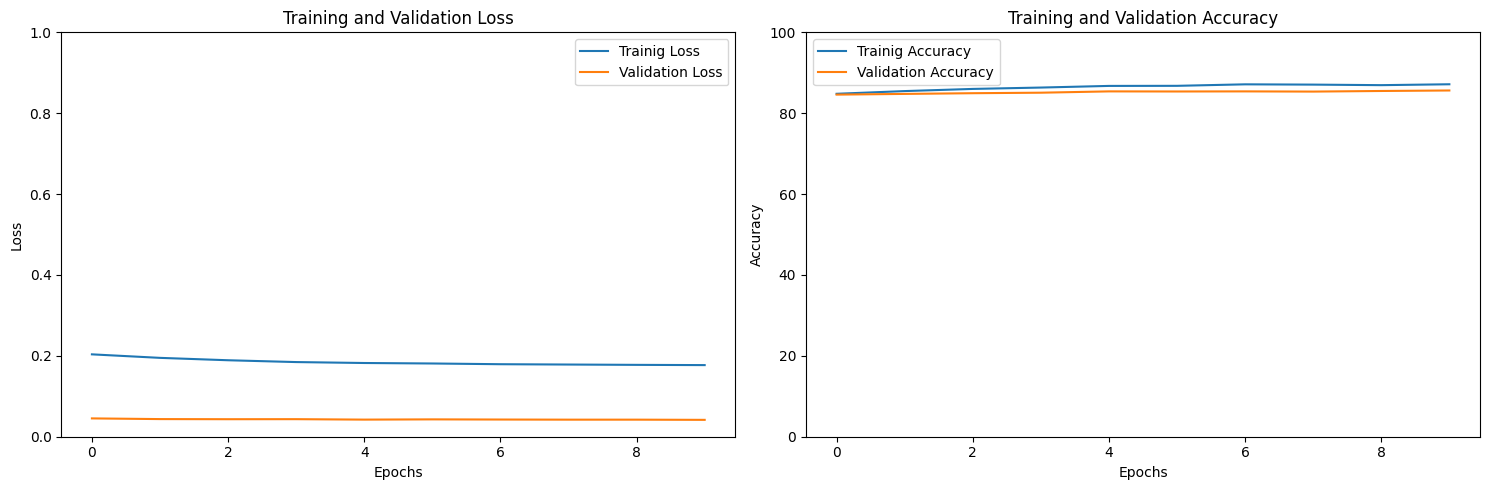

In [25]:
# Create a figure with two subplots to display loss and accuracy plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot training and validation loss
axs[0].plot(total_loss_train_plot, label = "Trainig Loss")
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,1]) # Set y-axis limits for better visualization
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(total_acc_train_plot, label = "Trainig Accuracy")
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100]) # Set y-axis limits for better visualization
axs[1].legend()

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
# Display the plots
plt.show()